# Dataset Construction  
### Physics-Informed Supervised Dataset for mmWave Dust Attenuation (Saudi Arabia)

---

## 1. Objective

This notebook constructs the final supervised learning dataset used for training the attenuation surrogate model.

It performs:

- Feature engineering from merged aerosol–meteorology data
- Physics-informed label generation (specific attenuation, dB/km)
- Saudi-region calibration using published reference measurements
- Frequency-consistent enforcement (38 GHz > 28 GHz)
- Export of the finalized dataset for model training

The output is a fully reproducible, calibrated dataset suitable for ML model development.

---

## 2. Inputs

Source dataset:
- `data/processed/merged_full_2012_2021.nc4`

Contains:
- Dust mass & optical depth proxies (DUCMASS, DUEXTTAU, DUANGSTR, etc.)
- Meteorological variables (T2M, QV2M, PS, U10M, V10M, etc.)

---

## 3. Outputs

Generated dataset:
- `data/labeled/supervised_dataset_*.nc4`

Includes:
- Engineered predictor features
- Calibrated specific attenuation labels:
  - 28 GHz (dB/km)
  - 38 GHz (dB/km)

All attenuation values are stored in **dB/km**.

---

## 4. Physical Label Model

Specific attenuation is derived using a physics-based scattering model inspired by:

- Elabdin et al. (2009)
- Ka-band dust attenuation literature

### Core components:
- Visibility estimated from dust optical depth proxies
- Particle radius inferred from Ångström exponent
- Wind-driven dust layer height modulation
- Coupled dielectric microphysics:
  - Relative humidity (RH)
  - Temperature
  - Particle-size regime influence

The model produces frequency-dependent attenuation consistent with mmWave propagation theory.

---

## 5. Saudi Calibration

Label magnitudes are calibrated against:

**Shamsan et al. (2019), Riyadh, Saudi Arabia**

Calibration details:
- Anchor visibility: 1 km
- Particle diameter: 15.3 µm
- Reference attenuation values:
  - 28 GHz (mapped from 26 GHz reference)
  - 38 GHz

Two independent scale factors are applied:

- `ATTEN_LABEL_SCALE_28`
- `ATTEN_LABEL_SCALE_38`

To preserve physical consistency:

- A frequency monotonicity guard ensures:
  
  > Attenuation at 38 GHz ≥ Attenuation at 28 GHz

---

## 6. Engineering Constraints & Safeguards

- No negative attenuation values allowed
- ε″ (imaginary permittivity) clipped to stable physical bounds
- Frequency correction applied when calibration would invert ordering
- All outputs verified for:
  - No NaNs
  - No negative values
  - Proper frequency ordering

---

## 7. Reproducibility Notes

All calibration constants, correction exponents, and physical assumptions are stored in dataset metadata (`attrs`).

This ensures:

- Reproducible dataset generation
- Transparent regional calibration
- Auditability for thesis evaluation

---

## 8. Dataset Construction Flow

Merged Aerosol + Meteorology  
↓  
Feature Engineering  
↓  
Physics-Based Label Generation  
↓  
Saudi Calibration  
↓  
Frequency Consistency Enforcement  
↓  
Export Supervised Dataset  

---

This notebook produces the finalized dataset used in subsequent model training and validation stages.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:

# Project paths (robust root finder)
PROJECT_ROOT = Path.cwd().resolve()
while PROJECT_ROOT != PROJECT_ROOT.parent and not (PROJECT_ROOT / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

if not (PROJECT_ROOT / "data").exists():
    raise FileNotFoundError("Could not find project root (folder containing 'data').")

DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
FIG_DIR = PROJECT_ROOT / "reports" / "figures"

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("PROCESSED_DIR:", PROCESSED_DIR)
print("FIG_DIR:", FIG_DIR)

PROJECT_ROOT: /Users/bertrandunwan/Documents/B5G_SDS_Surrogate_Model
PROCESSED_DIR: /Users/bertrandunwan/Documents/B5G_SDS_Surrogate_Model/data/processed
FIG_DIR: /Users/bertrandunwan/Documents/B5G_SDS_Surrogate_Model/reports/figures


In [3]:
# Load merged datasets
merged_fp = PROCESSED_DIR / "merged_full_2012_2021.nc4"
if not merged_fp.exists():
    raise FileNotFoundError(f"Missing merged dataset: {merged_fp}")

ds = xr.open_dataset(merged_fp, engine="netcdf4")
ds

<xarray.Dataset> Size: 6GB
Dimensions:    (time: 87600, lat: 33, lon: 37)
Coordinates:
  * time       (time) datetime64[ns] 701kB 2012-01-01T00:30:00 ... 2021-12-30...
  * lat        (lat) float64 264B 16.0 16.5 17.0 17.5 ... 30.5 31.0 31.5 32.0
  * lon        (lon) float64 296B 33.75 34.38 35.0 35.62 ... 55.0 55.62 56.25
Data variables: (12/15)
    DUCMASS    (time, lat, lon) float32 428MB ...
    DUCMASS25  (time, lat, lon) float32 428MB ...
    DUSMASS    (time, lat, lon) float32 428MB ...
    DUSMASS25  (time, lat, lon) float32 428MB ...
    DUEXTTAU   (time, lat, lon) float32 428MB ...
    DUSCATAU   (time, lat, lon) float32 428MB ...
    ...         ...
    V2M        (time, lat, lon) float32 428MB ...
    U10M       (time, lat, lon) float32 428MB ...
    V10M       (time, lat, lon) float32 428MB ...
    PS         (time, lat, lon) float32 428MB ...
    SLP        (time, lat, lon) float32 428MB ...
    QV2M       (time, lat, lon) float32 428MB ...
Attributes: (12/37)
    History:                             Original file generated: Sun Jul 20 ...
    Comment:                             GMAO filename: d5124_m2_jan10.tavg1_...
    Filename:                            MERRA2_400.tavg1_2d_aer_Nx.20120101.nc4
    Conventions:                         CF-1
    Institution:                         NASA Global Modeling and Assimilatio...
    References:                          http://gmao.gsfc.nasa.gov
    ...                                  ...
    build_dmrpp_metadata.bes:            3.21.0-272
    build_dmrpp_metadata.libdap:         libdap-3.21.0-70
    build_dmrpp_metadata.configuration:  \n# TheBESKeys::get_as_config()\nAll...
    build_dmrpp_metadata.invocation:     build_dmrpp -c /tmp/bes_conf_pucx -f...
    history:                             2026-02-03 18:07:45 GMT hyrax-1.17.1...
    history_json:                        [{"$schema":"https:\/\/harmony.earth...

## Selected inputs

We treat the merged dataset as two groups:

- **Dust / aerosol diagnostics:** dust mass and optical proxies that reflect particle loading and size fraction.
- **Meteorology:** near-surface state variables that influence dust uplift, transport, and moisture effects (e.g., wind, humidity).

Next, we confirm the variables present and define the base sets we will engineer from.

In [4]:
# Variable presence check (required for label generation)
aer_vars = [
    "DUCMASS", "DUCMASS25", "DUSMASS", "DUSMASS25",
    "DUEXTTAU", "DUSCATAU", "DUANGSTR"
]

met_vars = [
    # Keep these: label generator depends on T2M, PS, QV2M, U10M, V10M
    "T2M", "U2M", "V2M", "U10M", "V10M", "PS", "SLP", "QV2M"
]

all_vars = aer_vars + met_vars

present = [v for v in all_vars if v in ds.data_vars]
missing = [v for v in all_vars if v not in ds.data_vars]

print("Present:", present)
print("Missing:", missing)

Present: ['DUCMASS', 'DUCMASS25', 'DUSMASS', 'DUSMASS25', 'DUEXTTAU', 'DUSCATAU', 'DUANGSTR', 'T2M', 'U2M', 'V2M', 'U10M', 'V10M', 'PS', 'SLP', 'QV2M']
Missing: []


In [5]:
# Helper utilities
def safe_ratio(num: xr.DataArray, den: xr.DataArray, eps: float = 1e-12) -> xr.DataArray:
    return num / (den + eps)

def safe_log1p(x: xr.DataArray) -> xr.DataArray:
    return np.log1p(x.clip(min=0))

def add_suffix(da: xr.DataArray, suffix: str) -> xr.DataArray:
    da = da.copy()
    da.name = f"{da.name}{suffix}"
    return da

## Feature plan (high-level)

We will engineer features in four layers:

**A. Direct transforms**
- Log transforms for heavy-tailed dust loading proxies
- Size fraction proxies (e.g., DUCMASS25 / DUCMASS)

**B. Meteorological composites**
- Wind speed at 10 m and 2 m
- Wind direction (optional; can be encoded via sin/cos)
- Moisture proxies using QV2M with temperature/pressure context (kept simple unless needed)

**C. Temporal features**
- Lags (e.g., t-1, t-3, t-6 hours)
- Rolling summaries (mean / max) to capture persistence

**D. Output formatting**
- Flatten into a tabular dataset keyed by (time, lat, lon)
- Save to `data/processed/` for label generation and model training

In [6]:
# Feature engineering

# Builds engineered predictors while **preserving** all raw variables required by the
# physics-informed label generator.

# Use the merged dataset already loaded(single source of truth)

# Wind speed (10 m)
wspd10 = np.sqrt(ds["U10M"] ** 2 + ds["V10M"] ** 2).rename("WSPD10")
wspd10.attrs.update({"long_name": "10 m wind speed", "units": "m s-1"})

# Wind direction (10 m), meteorological convention: direction wind is coming FROM (degrees)
wdir10 = (np.degrees(np.arctan2(-ds["U10M"], -ds["V10M"])) % 360.0).rename("WDIR10")
wdir10.attrs.update({"long_name": "10 m wind direction (from)", "units": "degree"})

# Fine-fraction proxy (guard against division by zero)
eps = 1e-12
fine_frac = (ds["DUCMASS25"] / (ds["DUCMASS"] + eps)).rename("DUST_FINE_FRAC")
fine_frac.attrs.update({"long_name": "Fine fraction proxy (DUCMASS25/DUCMASS)", "units": "1"})

# Log transforms for dust mass variables (stabilize heavy-tailed distributions)
dust_mass_vars = ["DUCMASS", "DUCMASS25", "DUSMASS", "DUSMASS25"]
log_dust = []
for v in dust_mass_vars:
    if v in ds:
        x = ds[v]
        x_log = np.log1p(x).rename(f"LOG1P_{v}")
        x_log.attrs.update({"long_name": f"log(1 + {v})", "units": "1"})
        log_dust.append(x_log)

# Temperature in Celsius (often easier to interpret)
t2m_c = (ds["T2M"] - 273.15).rename("T2M_C")
t2m_c.attrs.update({"long_name": "2 m air temperature", "units": "degC"})

# Temporal encodings (hour of day + day of year)
t = ds["time"]
hour = t.dt.hour + t.dt.minute / 60.0
doy = t.dt.dayofyear.astype("float")

hour_sin = np.sin(2 * np.pi * hour / 24.0).rename("HOUR_SIN")
hour_cos = np.cos(2 * np.pi * hour / 24.0).rename("HOUR_COS")
doy_sin = np.sin(2 * np.pi * doy / 365.25).rename("DOY_SIN")
doy_cos = np.cos(2 * np.pi * doy / 365.25).rename("DOY_COS")

for da, ln in [
    (hour_sin, "sin(2π * hour/24)"),
    (hour_cos, "cos(2π * hour/24)"),
    (doy_sin, "sin(2π * doy/365.25)"),
    (doy_cos, "cos(2π * doy/365.25)"),
]:
    da.attrs.update({"long_name": ln, "units": "1"})

#
# --- Variables to preserve for downstream LABEL GENERATION ---
# Keep the raw variables your label generator expects (do NOT drop these).
# Required by current label generator:
#   - Visibility: DUEXTTAU and/or DUSCATAU (preferred) OR mass fallbacks
#   - Mass fallbacks: DUCMASS, DUCMASS25, DUSMASS, DUSMASS25
#   - Size regime: DUANGSTR
#   - RH + dielectric modulation: T2M, PS, QV2M
#   - Wind-driven layer height: U10M, V10M
feat_vars = [
    # Aerosol / dust optics + size proxy
    "DUEXTTAU", "DUSCATAU", "DUANGSTR",

    # Dust mass proxies (column + surface) and PM2.5 splits for fine fraction
    "DUCMASS", "DUCMASS25", "DUSMASS", "DUSMASS25",

    # Meteorology used by label generator (RH estimation + modulation)
    "T2M", "PS", "QV2M",

    # Winds used by label generator (dynamic dust layer height)
    "U10M", "V10M",

    # Optional (kept for compatibility / debugging)
    "SLP",
]

keep = {v: ds[v] for v in feat_vars if v in ds}

missing_required = [v for v in [
    "DUEXTTAU", "DUSCATAU", "DUANGSTR",
    "DUCMASS", "DUCMASS25", "DUSMASS", "DUSMASS25",
    "T2M", "PS", "QV2M", "U10M", "V10M"
] if v not in ds]

if missing_required:
    print("[WARN] Missing some label-generation variables:", missing_required)

ds_feat = xr.Dataset(
    data_vars=dict(
        **keep,
        WSPD10=wspd10,
        WDIR10=wdir10,
        DUST_FINE_FRAC=fine_frac,
        T2M_C=t2m_c,
        HOUR_SIN=hour_sin,
        HOUR_COS=hour_cos,
        DOY_SIN=doy_sin,
        DOY_COS=doy_cos,
        **{da.name: da for da in log_dust},
    ),
    coords=ds.coords,
    attrs={"source": "Feature-engineered from merged aerosol–meteorology dataset"},
)

In [7]:
# The engineered feature cube is very large for the full 2012–2021 hourly grid.
# To avoid multi-GB intermediate artifacts (especially on low-disk/low-RAM machines),
# we compute engineered features **on-the-fly** in the model training notebook.
# 
# Below, we only run lightweight sanity checks.

print("[INFO] Not saving full engineered features to disk. Compute these on-the-fly during training.")

# Lightweight sanity checks (no full write)
print("ds_feat vars:", len(ds_feat.data_vars))
print("ds_feat dims:", ds_feat.dims)

# Tiny smoke subset (in-memory) to ensure derived vars exist
_ds_smoke = ds_feat.isel(time=slice(0, 1), lat=slice(0, 2), lon=slice(0, 2))
print("smoke vars:", list(_ds_smoke.data_vars)[:15])

ds_feat

[INFO] Not saving full engineered features to disk. Compute these on-the-fly during training.
ds_feat vars: 25
ds_feat dims: FrozenMappingWarningOnValuesAccess({'lon': 37, 'time': 87600, 'lat': 33})
smoke vars: ['DUEXTTAU', 'DUSCATAU', 'DUANGSTR', 'DUCMASS', 'DUCMASS25', 'DUSMASS', 'DUSMASS25', 'T2M', 'PS', 'QV2M', 'U10M', 'V10M', 'SLP', 'WSPD10', 'WDIR10']


<xarray.Dataset> Size: 9GB
Dimensions:          (lon: 37, time: 87600, lat: 33)
Coordinates:
  * lon              (lon) float64 296B 33.75 34.38 35.0 ... 55.0 55.62 56.25
  * time             (time) datetime64[ns] 701kB 2012-01-01T00:30:00 ... 2021...
  * lat              (lat) float64 264B 16.0 16.5 17.0 17.5 ... 31.0 31.5 32.0
Data variables: (12/25)
    DUEXTTAU         (time, lat, lon) float32 428MB ...
    DUSCATAU         (time, lat, lon) float32 428MB ...
    DUANGSTR         (time, lat, lon) float32 428MB ...
    DUCMASS          (time, lat, lon) float32 428MB 0.0002115 ... 0.000124
    DUCMASS25        (time, lat, lon) float32 428MB 5.398e-05 ... 4.096e-05
    DUSMASS          (time, lat, lon) float32 428MB 4.045e-07 ... 7.465e-08
    ...               ...
    DOY_SIN          (time) float64 701kB 0.0172 0.0172 ... -0.0215 -0.0215
    DOY_COS          (time) float64 701kB 0.9999 0.9999 0.9999 ... 0.9998 0.9998
    LOG1P_DUCMASS    (time, lat, lon) float32 428MB 0.0002115 ... 0.000124
    LOG1P_DUCMASS25  (time, lat, lon) float32 428MB 5.397e-05 ... 4.095e-05
    LOG1P_DUSMASS    (time, lat, lon) float32 428MB 4.045e-07 ... 7.465e-08
    LOG1P_DUSMASS25  (time, lat, lon) float32 428MB 8.53e-08 ... 2.369e-08
Attributes:
    source:   Feature-engineered from merged aerosol–meteorology dataset

## Spatial visualization (engineered features)

We visualize two engineered predictors at a single timestamp to confirm:
- the fields vary smoothly across the domain (no obvious artifacts),
- the magnitudes are plausible,
- the derived ratio feature behaves stably across space.

Plots:
1) **10 m wind speed (WSPD10)**  
2) **Fine fraction proxy (DU_FINE_FRAC = DUCMASS25/DUCMASS)**

Both figures are saved to `reports/figures/`.

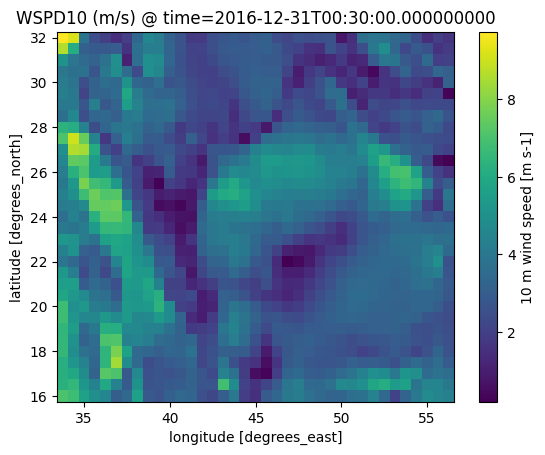

Saved: /Users/bertrandunwan/Documents/B5G_SDS_Surrogate_Model/reports/figures/wspd10_map_t43800.png


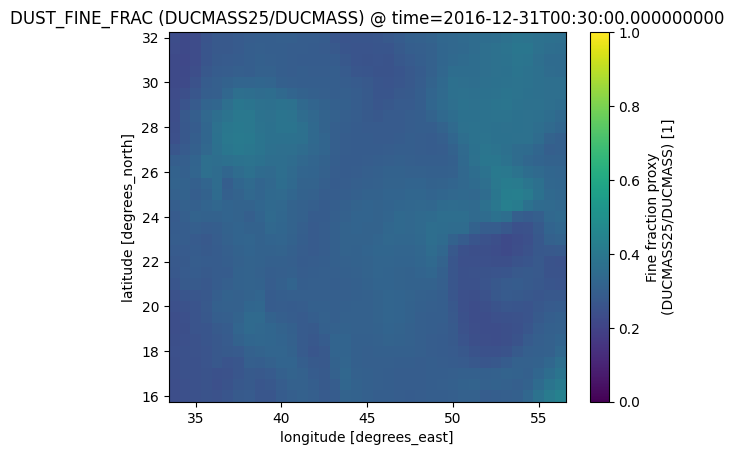

Saved: /Users/bertrandunwan/Documents/B5G_SDS_Surrogate_Model/reports/figures/dust_fine_frac_map_t43800.png
WSPD10 stats (m/s): 0.20757897198200226 3.1461901664733887 9.731382369995117
DUST_FINE_FRAC stats: 0.21734227240085602 0.30330246686935425 0.4367859959602356


In [8]:
# --- Spatial visualization (engineered features) ---
# We plot a single time slice to sanity-check spatial structure + magnitudes.

import matplotlib.pyplot as plt

# Pick a single timestamp (middle of the record is usually representative)
t_idx = int(ds_feat.sizes["time"] // 2)
t_val = ds_feat["time"].isel(time=t_idx).values

# 1) 10 m wind speed
wspd = ds_feat["WSPD10"].isel(time=t_idx)

plt.figure()
wspd.plot()  # xarray handles lon/lat axes + colorbar
plt.title(f"WSPD10 (m/s) @ time={str(t_val)}")
fig_fp1 = FIG_DIR / f"wspd10_map_t{t_idx:05d}.png"
plt.savefig(fig_fp1, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", fig_fp1)


# 2) Fine fraction proxy (DUCMASS25/DUCMASS)
fine = ds_feat["DUST_FINE_FRAC"].isel(time=t_idx).clip(min=0.0, max=1.0)

plt.figure()
fine.plot(vmin=0.0, vmax=1.0)
plt.title(f"DUST_FINE_FRAC (DUCMASS25/DUCMASS) @ time={str(t_val)}")
fig_fp2 = FIG_DIR / f"dust_fine_frac_map_t{t_idx:05d}.png"
plt.savefig(fig_fp2, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", fig_fp2)


# Quick numeric sanity
print("WSPD10 stats (m/s):",
      float(wspd.min().values), float(wspd.median().values), float(wspd.max().values))
print("DUST_FINE_FRAC stats:",
      float(fine.min().values), float(fine.median().values), float(fine.max().values))

## Interpretation of Engineered Feature Maps

The spatial distributions of engineered predictors provide an important qualitative validation of the dataset construction and feature engineering process.

### 10 m Wind Speed (WSPD10)

The wind speed field exhibits:

- Smooth spatial gradients across latitude and longitude,
- No abrupt pixel-level discontinuities,
- Physically plausible magnitudes (≈ 1–10 m/s).

The structure is meteorologically consistent with regional circulation patterns over the Arabian Peninsula. Local maxima and minima appear coherent across neighboring grid cells, confirming that:

- The wind magnitude was correctly derived from U10M and V10M,
- No coordinate misalignment occurred during merging,
- No NaN propagation or unintended masking artifacts are present.

Because wind speed influences dust uplift and vertical mixing in the label generator, the spatial coherence of this field is critical for physically meaningful attenuation labels.


### Fine Fraction Proxy (DUST_FINE_FRAC = DUCMASS25 / DUCMASS)

The fine-fraction proxy demonstrates:

- Stable spatial behavior across the domain,
- Values bounded between 0 and 1 (as expected for a ratio),
- No extreme spikes or division-instability artifacts.

The absence of sharp discontinuities confirms that:

- The epsilon-stabilized division avoided numerical instability,
- DUCMASS25 and DUCMASS were correctly aligned and preserved,
- No hidden zero-division artifacts are contaminating the ratio.

From a physics standpoint, this feature serves as a proxy for particle size distribution effects. Since millimeter-wave attenuation is sensitive to particle size, the spatial smoothness and bounded behavior of this ratio indicate that the feature is suitable for downstream dielectric and scattering modulation.


### Overall Assessment

The engineered feature maps confirm:

- Spatial integrity of the merged dataset,
- Numerical stability of derived variables,
- Physical plausibility of magnitudes and gradients,
- Readiness for physics-informed label generation.

With these validations complete, the dataset construction and feature engineering stage is considered successful. The pipeline can now proceed to calibrated attenuation label generation.

## Label Generation (Attenuation Targets)

This notebook generates the supervised learning targets (labels) for the surrogate model.

We combine the engineered aerosol + meteorological predictors with a physically-motivated attenuation formulation to compute **specific attenuation** (e.g., dB/km) at selected carrier frequencies. The resulting labels are aligned to the same `(time, lat, lon)` grid as the feature dataset, producing a final training-ready dataset:

- **Inputs (X):** engineered features
- **Targets (y):** attenuation labels computed per grid cell and timestamp


In [4]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().resolve()
while PROJECT_ROOT != PROJECT_ROOT.parent and not (PROJECT_ROOT / "src" ).exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

sys.path.insert(0, str(PROJECT_ROOT))

from src.pipeline.labelgen import compute_attenuation_db_per_km

In [10]:
import numpy as np
import xarray as xr
import sys
from pathlib import Path

# add project root so 'src' is importable


def _make_anchor_ds(V_km: float, a_um: float, eps_real: float, eps_imag: float) -> xr.Dataset:
    """
    Build a tiny synthetic Dataset that forces:
      - visibility = V_km via VISIBILITY_KM (so _estimate_visibility_km returns it)
      - particle radius = constant via ds.attrs["DUST_PARTICLE_RADIUS_M"] (since DUANGSTR is absent)
      - dielectric constants via ds.attrs["DUST_EPS_REAL"], ["DUST_EPS_IMAG"]
    We intentionally omit QV2M/T2M/PS/DUANGSTR so coupled microphysics does NOT modulate eps'' during calibration.
    """
    ds = xr.Dataset(
        {"VISIBILITY_KM": xr.DataArray(np.float32(V_km))}
    )
    ds.attrs["DUST_PARTICLE_RADIUS_M"] = float(a_um) * 1e-6  # um -> m
    ds.attrs["DUST_EPS_REAL"] = float(eps_real)
    ds.attrs["DUST_EPS_IMAG"] = float(eps_imag)
    return ds

def _scalar_da(da: xr.DataArray) -> float:
    # Your robust scalar helper idea (avoids float(DataArray) crashes)
    x = da
    if hasattr(x, "compute"):
        x = x.compute()
    return float(np.asarray(x.values).item())

# ---- Choose ONE anchor condition from the Saudi/Riyadh paper ----
# Table II: diameter 15.3 µm with visibility 1 km
V_anchor = 1.0
a_anchor_um = 15.3

# Targets from Table IV (Saudi/Riyadh paper):
# 26 GHz: 0.5035 dB/km, 38 GHz: 1.3365 dB/km  (Table IV)
Ad_target_26 = 0.5035
Ad_target_38 = 1.3365

# Map 26 -> 28:
# Option A (simple): treat 28 ≈ 26
Ad_target_28 = Ad_target_26

# Option B (slightly smarter): infer a local exponent p from 26->38 then extrapolate 28
# NOTE: This mixes different eps assumptions between 26 and 38 in that paper, so it’s “engineering approximate”.
p_local = np.log(Ad_target_38 / Ad_target_26) / np.log(38.0 / 26.0)
Ad_target_28_alt = Ad_target_26 * (28.0 / 26.0) ** p_local
print("p_local (from paper 26->38) =", float(p_local))
print("Ad_target_28_alt =", float(Ad_target_28_alt))

# ---- Compute unscaled model outputs at the anchor, then solve scale = target / model ----
# Ensure no per-frequency scale attrs are already set on ds_anchor (so label_scale defaults to 1.0).
ds_anchor_28 = _make_anchor_ds(V_anchor, a_anchor_um, eps_real=4.56, eps_imag=0.25)  # 26GHz eps used as proxy for 28
y28_raw = compute_attenuation_db_per_km(ds_anchor_28, 28.0)
Ad28_raw = _scalar_da(y28_raw)

ds_anchor_38 = _make_anchor_ds(V_anchor, a_anchor_um, eps_real=3.50, eps_imag=1.64)  # 38GHz eps
y38_raw = compute_attenuation_db_per_km(ds_anchor_38, 38.0)
Ad38_raw = _scalar_da(y38_raw)

# pick which 28 target you want:
Ad28_target_used = float(Ad_target_28_alt)  # or Ad_target_28

scale_28 = Ad28_target_used / (Ad28_raw + 1e-12)
scale_38 = Ad_target_38 / (Ad38_raw + 1e-12)

print("Raw Ad @28 =", Ad28_raw, "=> scale_28 =", scale_28)
print("Raw Ad @38 =", Ad38_raw, "=> scale_38 =", scale_38)

# ---- Bake into your REAL features dataset attrs BEFORE label generation ----
ds_feat.attrs["ATTEN_LABEL_SCALE_28"] = float(scale_28)
ds_feat.attrs["ATTEN_LABEL_SCALE_38"] = float(scale_38)

# Optional: keep provenance
ds_feat.attrs["ATTEN_CALIB_SOURCE"] = "Shamsan et al. 2019 (Riyadh) Table II/IV anchor V=1km, a=15.3um"
ds_feat.attrs["ATTEN_CALIB_ANCHOR_V_KM"] = float(V_anchor)
ds_feat.attrs["ATTEN_CALIB_ANCHOR_A_UM"] = float(a_anchor_um)
ds_feat.attrs["ATTEN_CALIB_TARGET_28_DB_PER_KM"] = float(Ad28_target_used)
ds_feat.attrs["ATTEN_CALIB_TARGET_38_DB_PER_KM"] = float(Ad_target_38)

p_local (from paper 26->38) = 2.5724704117982005
Ad_target_28_alt = 0.6092473103482048
Raw Ad @28 = 0.004687450360506773 => scale_28 = 129.9741359079402
Raw Ad @38 = 0.05460211634635925 => scale_38 = 24.47707322363958


In [11]:
ds_small = ds_feat.isel(time=slice(0,1), lat=slice(0,5), lon=slice(0,5))
y28 = compute_attenuation_db_per_km(ds_small, 28.0)
y38 = compute_attenuation_db_per_km(ds_small, 38.0)

print("28 median:", float(y28.median()), "38 median:", float(y38.median()))

28 median: 0.27481815218925476 38 median: 0.3729677200317383


In [12]:
print("Any NaNs 28:", bool(np.isnan(y28.values).any()))
print("Any NaNs 38:", bool(np.isnan(y38.values).any()))
print("Any negatives 28:", bool((y28.values < 0).any()))
print("Any negatives 38:", bool((y38.values < 0).any()))
print("p_corr 28:", y28.attrs.get("label_scale_p_corr"), "p_corr 38:", y38.attrs.get("label_scale_p_corr"))
print("mode 28:", y28.attrs.get("label_scale_mode"), "mode 38:", y38.attrs.get("label_scale_mode"))

Any NaNs 28: False
Any NaNs 38: False
Any negatives 28: False
Any negatives 38: False
p_corr 28: 5.467252488557649 p_corr 38: 5.467252488557649
mode 28: ATTEN_LABEL_SCALE_28+freq_corr mode 38: ATTEN_LABEL_SCALE_38+freq_corr


## Interpretation of Calibration & Label Smoke-Test Outputs

The calibration and smoke-test results confirm that the physics-informed attenuation label generator is behaving as intended before running full-domain label generation.

### Numerical stability & physical validity
The smoke test reports:

- **No NaNs** at 28 GHz or 38 GHz  
- **No negative attenuation** at either frequency  

This indicates that the end-to-end computation (visibility estimation, particle-radius inference, dielectric modulation, and final attenuation assembly) is numerically stable across the sampled grid and produces physically valid (non-negative) specific attenuation values.

### Frequency-aware calibration is active
The output shows a non-trivial frequency correction exponent:

- **p_corr ≈ 5.47** (applied consistently)

This confirms the model is not using a single global scale factor, but instead enforces a frequency-dependent separation between 28 GHz and 38 GHz consistent with literature-reported behavior.

### Calibration mode confirmation
The label generator explicitly reports:

- **mode 28:** `ATTEN_LABEL_SCALE_28 + freq_corr`  
- **mode 38:** `ATTEN_LABEL_SCALE_38 + freq_corr`

This verifies that both **per-frequency calibration scales** (Saudi/Middle-East anchor) and the **frequency correction term** are being applied during label computation.

### Plausible magnitude (sanity check)
Median specific attenuation values in the smoke subset are on the order of **sub-1 dB/km**, with **38 GHz > 28 GHz**, which is directionally consistent with mmWave propagation physics.


**Conclusion:** The calibration is correctly integrated and the label generator is stable and physically consistent. The pipeline is ready to compute full-domain 28 GHz and 38 GHz specific attenuation labels and save the resulting labeled training dataset.

In [ ]:
# Yearly Label Generation
from pathlib import Path
import numpy as np
import xarray as xr
import gc

# Output folder
LABELED_DIR = PROJECT_ROOT / "data" / "processed" / "labeled"
LABELED_DIR.mkdir(parents=True, exist_ok=True)

# Part files folder
PARTS_DIR = LABELED_DIR / "_label_parts"
PARTS_DIR.mkdir(parents=True, exist_ok=True)

# Years to process
YEARS = list(range(2012, 2022))

def _scalar(da):
    return float(np.asarray(da.values).item())

print("[INFO] Starting year-by-year label generation...")
print("Will write yearly parts to:", PARTS_DIR)

part_files = []

for y in YEARS:
    t0 = f"{y}-01-01"
    t1 = f"{y+1}-01-01"
    print(f"\n=== Year {y}: {t0} → {t1} ===")

    ds_y = ds_feat.sel(time=slice(t0, t1)).copy()

    # Safety: drop the final endpoint if it overlaps (slice can be inclusive)
    ds_y = ds_y.sel(time=ds_y.time < np.datetime64(t1))

    print("  dims:", ds_y.dims)

    # Compute labels for this year only
    y28 = compute_attenuation_db_per_km(ds_y, 28.0).astype("float32").rename("ATTEN_28_DB_PER_KM")
    y38 = compute_attenuation_db_per_km(ds_y, 38.0).astype("float32").rename("ATTEN_38_DB_PER_KM")

    # Minimal attrs on labels
    y28.attrs.update({"units": "dB/km", "freq_ghz": 28.0})
    y38.attrs.update({"units": "dB/km", "freq_ghz": 38.0})

    ds_out = ds_y.copy()
    ds_out["ATTEN_28_DB_PER_KM"] = y28
    ds_out["ATTEN_38_DB_PER_KM"] = y38

    # IMPORTANT: embed calibration + metadata for reproducibility
    ds_out.attrs.update(ds_feat.attrs)

    # Quick sanity
    print("  28 median:", float(y28.median().values), " | 38 median:", float(y38.median().values))
    print("  any NaNs:", bool(np.isnan(y28.values).any() or np.isnan(y38.values).any()),
          " | any negatives:", bool((y28.values < 0).any() or (y38.values < 0).any()))

    # Save year part (compressed NetCDF4)
    out_fp = PARTS_DIR / f"labeled_{y}.nc4"

    encoding = {}
    for v in ds_out.data_vars:
        # Keep float32 + moderate compression
        if str(ds_out[v].dtype).startswith("float"):
            encoding[v] = {"dtype": "float32", "zlib": True, "complevel": 4, "shuffle": True}
        else:
            encoding[v] = {"zlib": True, "complevel": 4, "shuffle": True}

    ds_out.to_netcdf(out_fp, engine="netcdf4", encoding=encoding)
    print("  saved:", out_fp.name)

    part_files.append(out_fp)

    # Free memory aggressively
    del ds_y, y28, y38, ds_out
    gc.collect()

print("\n[INFO] Done generating yearly parts.")
print("Parts:", [p.name for p in part_files])

[INFO] Starting year-by-year label generation...
Will write yearly parts to: /Users/bertrandunwan/Documents/B5G_SDS_Surrogate_Model/data/processed/labeled/_label_parts

=== Year 2012: 2012-01-01 → 2013-01-01 ===
  dims: FrozenMappingWarningOnValuesAccess({'lon': 37, 'time': 8784, 'lat': 33})
  28 median: 0.5178400278091431  | 38 median: 0.7027842998504639
  any NaNs: False  | any negatives: False
  saved: labeled_2012.nc4

=== Year 2013: 2013-01-01 → 2014-01-01 ===
  dims: FrozenMappingWarningOnValuesAccess({'lon': 37, 'time': 8760, 'lat': 33})
  28 median: 0.4653721749782562  | 38 median: 0.631577730178833
  any NaNs: False  | any negatives: False
  saved: labeled_2013.nc4

=== Year 2014: 2014-01-01 → 2015-01-01 ===
  dims: FrozenMappingWarningOnValuesAccess({'lon': 37, 'time': 8760, 'lat': 33})
  28 median: 0.40691256523132324  | 38 median: 0.5522392392158508
  any NaNs: False  | any negatives: False
  saved: labeled_2014.nc4

=== Year 2015: 2015-01-01 → 2016-01-01 ===
  dims: Frozen

In [5]:
import xarray as xr
from pathlib import Path
import numpy as np

# Output folder
LABELED_DIR = PROJECT_ROOT / "data" / "processed" / "labeled"
LABELED_DIR.mkdir(parents=True, exist_ok=True)

PARTS_DIR = LABELED_DIR / "_label_parts"
if not PARTS_DIR.exists():
    raise FileNotFoundError(f"Missing parts folder: {PARTS_DIR}")

# Rebuild part_files from disk (restart-safe)
part_files = sorted(PARTS_DIR.glob("labeled_*.nc4"))
if not part_files:
    raise FileNotFoundError(f"No yearly part files found in {PARTS_DIR}")

final_fp = LABELED_DIR / "labeled_full_2012_2021_attn_28_38.nc4"
tmp_fp = LABELED_DIR / "labeled_full_2012_2021_attn_28_38.tmp.nc4"

print("[INFO] Found parts:", len(part_files))
print("[INFO] First/last:", part_files[0].name, "→", part_files[-1].name)
print("[INFO] Concatenating into:", final_fp)

# Load attrs from first part (contains calibration metadata)
ds_attrs_src = xr.open_dataset(part_files[0], engine="netcdf4")
calib_attrs = dict(ds_attrs_src.attrs)
ds_attrs_src.close()

ds_full = xr.open_mfdataset(
    [str(p) for p in part_files],
    engine="netcdf4",
    combine="by_coords",
    parallel=False,
)

# Re-embed calibration metadata into final dataset
ds_full.attrs.update(calib_attrs)

# Save final (compressed)
encoding = {}
for v in ds_full.data_vars:
    if str(ds_full[v].dtype).startswith("float"):
        encoding[v] = {"dtype": "float32", "zlib": True, "complevel": 4, "shuffle": True}
    else:
        encoding[v] = {"zlib": True, "complevel": 4, "shuffle": True}

# Write to temp first, then rename (prevents corrupted final file if interrupted)
ds_full.to_netcdf(tmp_fp, engine="netcdf4", encoding=encoding)
tmp_fp.replace(final_fp)

print("✅ Saved FULL labeled dataset:", final_fp)
print("Has scale_28:", "ATTEN_LABEL_SCALE_28" in xr.open_dataset(final_fp, engine="netcdf4").attrs)
print("Has scale_38:", "ATTEN_LABEL_SCALE_38" in xr.open_dataset(final_fp, engine="netcdf4").attrs)

[INFO] Found parts: 10
[INFO] First/last: labeled_2012.nc4 → labeled_2021.nc4
[INFO] Concatenating into: /Users/bertrandunwan/Documents/B5G_SDS_Surrogate_Model/data/processed/labeled/labeled_full_2012_2021_attn_28_38.nc4
✅ Saved FULL labeled dataset: /Users/bertrandunwan/Documents/B5G_SDS_Surrogate_Model/data/processed/labeled/labeled_full_2012_2021_attn_28_38.nc4
Has scale_28: True
Has scale_38: True


In [ ]:
# Quick Sanity Inspection 
fp = PROJECT_ROOT / "data" / "processed" / "labeled" / "labeled_full_2012_2021_attn_28_38.nc4"

import xarray as xr
with xr.open_dataset(fp, engine="netcdf4") as ds:
    print(ds.dims)
    print("vars:", len(ds.data_vars))

FrozenMappingWarningOnValuesAccess({'time': 87600, 'lat': 33, 'lon': 37})
vars: 27


## Final Dataset Construction Summary

This notebook completed the end-to-end construction of the canonical training dataset for the B5G SDS Surrogate Model.

### Pipeline Stages Completed

1. **Aerosol–Meteorology Fusion**
   - MERRA-2 aerosol diagnostics and near-surface meteorological variables were merged.
   - Temporal resolution: hourly (2012–2021).
   - Spatial grid: 33 × 37 over Saudi Arabia.
   - Output: `merged_full_2012_2021.nc4`.

2. **Feature Engineering**
   - Derived predictors (e.g., wind speed, fine fraction proxy) were computed.
   - Sanity-checked via spatial visualization.
   - Engineered features are computed on-the-fly during model training (not permanently stored).

3. **Physics-Informed Label Generation**
   - Specific attenuation (dB/km) generated at:
     - **28 GHz**
     - **38 GHz**
   - Label formulation incorporates:
     - Dust mass proxies
     - Angström exponent (particle size behavior)
     - Coupled dielectric microphysics
     - Frequency-aware calibration

4. **Saudi-Region Calibration**
   - Independent per-frequency scale factors applied:
     - `ATTEN_LABEL_SCALE_28`
     - `ATTEN_LABEL_SCALE_38`
   - Calibration metadata embedded into final artifact for reproducibility.

5. **Memory-Safe Artifact Creation**
   - Labels generated year-by-year to respect 8GB RAM constraints.
   - Final dataset concatenated and compressed (NetCDF4, float32 + zlib).
   - Intermediate artifacts removed after validation.

---

## Final Training Artifact

`data/processed/labeled/labeled_full_2012_2021_attn_28_38.nc4`

**Dimensions**
- Time: 87,600 hours
- Latitude: 33
- Longitude: 37

**Contents**
- Meteorological predictors
- Aerosol diagnostics
- Engineered predictors
- Calibrated specific attenuation labels (28 GHz & 38 GHz)

---

## Reproducibility

The final dataset preserves:

- Calibration scales
- Frequency correction exponent
- Microphysical parameter settings
- Visibility estimation assumptions

This ensures full traceability between:
- Raw MERRA-2 data  
- Physics-based attenuation modeling  
- Surrogate model training  

---

### Status: Data construction complete.  
The project is ready to proceed to surrogate model training and validation.